In [1]:
import numpy as np
import pandas as pd 
from BHDVCS_tf import BHDVCStf
from BHDVCS_tf import TotalFLayer
import utilities as uts
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

import sys
from scipy.stats import chisquare

tb = BHDVCStf()
f = tb.curve_fit

df = pd.read_csv("BKM_pseudodata.csv")
df = df.rename(columns={"sigmaF": "errF"})

data = uts.DvcsData(df)

def F2VsPhi(dataframe,SetNum,xdat,cffs):
    TempFvalSilces=dataframe[dataframe["#Set"]==SetNum]
    TempFvals=TempFvalSilces["F"]
    TempFvals_sigma=TempFvalSilces["errF"]
    temp_phi=TempFvalSilces["phi_x"]
    plt.errorbar(temp_phi,TempFvals,TempFvals_sigma,fmt='.',color='blue',label="Data")
    plt.xlim(0,368)
    temp_unit=(np.max(TempFvals)-np.min(TempFvals))/len(TempFvals)
    plt.ylim(np.min(TempFvals)-temp_unit,np.max(TempFvals)+temp_unit)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc=4,fontsize=10,handlelength=3)
    plt.title("Local fit with data set #"+str(SetNum),fontsize=20)
    print(xdat)
    print(cffs)
    plt.plot(temp_phi, f(xdat,cffs), 'g--', label='fit')
    file_name = "plot_set_number_{}.png".format(SetNum)
    plt.savefig(file_name)

In [15]:
setI = data.getSet(i, itemsInSet=45)
noCFF = tf.transpose(setI.XnoCFF)

f(noCFF, [15,10,3,-1])

<tf.Tensor: shape=(45,), dtype=float64, numpy=
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])>

In [2]:
kinematics = tf.keras.Input(shape=(4))
x1 = tf.keras.layers.Dense(100, activation="tanh")(kinematics)
x2 = tf.keras.layers.Dense(100, activation="tanh")(x1)
outputs = tf.keras.layers.Dense(4, activation="linear")(x2)
noncffInputs = tf.keras.Input(shape=(7))
#### phi, kin1, kin2, kin3, kin4, F1, F2 ####
total_FInputs = tf.keras.layers.concatenate([noncffInputs,outputs])
TotalF = TotalFLayer()(total_FInputs)

tfModel = tf.keras.Model(inputs=[kinematics, noncffInputs], outputs = TotalF, name="tfmodel")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=300)

tfModel.compile(
    optimizer = tf.keras.optimizers.Adam(.0085),
    loss = tf.keras.losses.MeanSquaredError()
)

Wsave = tfModel.get_weights()  

Tensor("total_f_layer/strided_slice:0", shape=(None, 7), dtype=float64)
Tensor("total_f_layer/strided_slice_1:0", shape=(None, 4), dtype=float64)


Epoch 1/5
Tensor("tfmodel/total_f_layer/strided_slice:0", shape=(1, 7), dtype=float64)
Tensor("tfmodel/total_f_layer/strided_slice_1:0", shape=(1, 4), dtype=float64)
Tensor("tfmodel/total_f_layer/strided_slice:0", shape=(1, 7), dtype=float64)
Tensor("tfmodel/total_f_layer/strided_slice_1:0", shape=(1, 4), dtype=float64)
45/45 [==============================] - 4s 3ms/step - loss: nan
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: nan
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: nan
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: nan
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: nan
    phi_x     k       QQ       x_b         t        F1        F2
0       8  2.75  1.05443  0.536279 -0.452256  0.439958  0.597371
1      16  2.75  1.05443  0.536279 -0.452256  0.439958  0.597371
2      24  2.75  1.05443  0.536279 -0.452256  0.439958  0.597371
3      32  2.75  1.05443  0.536279 -0.452256  0.43995

TypeError: ignored

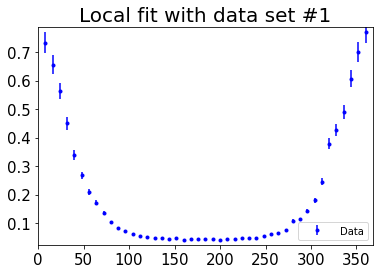

In [3]:
#Number of kinematic sets
by_set = []
for i in range(1):
  setI = data.getSet(i, itemsInSet=45)

  tfModel.set_weights(Wsave)

  tfModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(), # one replica of samples from F vals
                        epochs=5, verbose=1, batch_size=1, callbacks=[early_stopping_callback])
  
  cffs = uts.cffs_from_globalModel(tfModel, setI.Kinematics, numHL=2)
  

  by_set.append(cffs)
  xdat = tf.transpose(setI.XnoCFF)

  F2VsPhi(df,i+1,setI.XnoCFF,cffs)
  plt.clf()

In [5]:
by_set

[array([nan, nan, nan, nan], dtype=float32),
 array([nan, nan, nan, nan], dtype=float32),
 array([nan, nan, nan, nan], dtype=float32),
 array([nan, nan, nan, nan], dtype=float32),
 array([nan, nan, nan, nan], dtype=float32)]